<a href="https://colab.research.google.com/github/WasecResiner/OFDR_final/blob/main/OFDR_(final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title финальная версия программы по обработке OFDR

In [1]:
#@title импорт библиотек
import configparser
import os
import ast
import re  # Добавлено для использования регулярных выражений
import tkinter as tk
from tkinter import ttk, messagebox, filedialog
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import correlate, convolve, hilbert
from numba import njit, prange
from numba.typed import List
import time

In [7]:
#@title подключение гугл диска
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title bash clone
%%bash
# 1) Создаём папку “Colab Notebooks” на Drive, если её ещё нет
mkdir -p "/content/drive/My Drive/Colab Notebooks"

# 2) Копируем ноутбук (перебросим его в папку Colab Notebooks)
#    Замените OFDR_final.ipynb на точное имя вашего файла, если отличается
cp "/content/OFDR_(final).ipynb" "/content/drive/My Drive/Colab Notebooks/OFDR_final.ipynb"

# 3) Опционально: проверим, что копия появилась
ls -la "/content/drive/My Drive/Colab Notebooks"


In [ ]:
#@title load_settings
def load_settings(filepath, defaults):
    global SIM_FIBER_LENGTH, SIM_FIBER_SPACING, SIM_LASER_FREQ_START, SIM_LASER_FREQ_STOP, SIM_FIBER_IMPW, SIM_FIBER_IMPPT
    global SIM_FIBER_IMPMIN, SIM_FIBER_IMPMAX, SIM_FIBER_IMPV, SIM_LASER_SWEEP_RATE, SIM_ADC_F, SIM_FIBER_N, SIM_STRAIN_GAUGE
    global SIM_STRAIN_STEP, SIM_STRAIN_CORR_THRESH, C, MEAS_FIBER_N, MEAS_FIBER_BEGIN, MEAS_FIBER_END, MEAS_FIBER_REFSEG_BEGIN, MEAS_FIBER_REFSEG_END
    global MEAS_FIBER_MZ_N, MEAS_LASER_FREQ_START, MEAS_LASER_FREQ_STOP, MEAS_LASER_SWEEP_RATE, MEAS_ADC_F, MEAS_ADC_T_SCANUP, MEAS_REF_FREQ_FULLSCAN_START
    global MEAS_REF_FREQ_FULLSCAN_STOP, MEAS_REF_M_SUBSCAN, MEAS_REF_SCAN_GAP, MEAS_ADC_T_UP_START, MEAS_ADC_T_UP_STOP, MEAS_ADC_T_DOWN_START, MEAS_ADC_T_DOWN_STOP
    global CSV_COLUMN_MAP, MEAS_LASER_PHASE_STEP # Added global variable for CSV mapping and the new constant

    config = configparser.ConfigParser()

    if os.path.exists(filepath):
        config.read(filepath)

        if 'SIM_FIBER' in config:
            SIM_FIBER_LENGTH = config.getfloat('SIM_FIBER', 'SIM_FIBER_LENGTH', fallback=defaults['SIM_FIBER']['SIM_FIBER_LENGTH'])
            SIM_FIBER_SPACING = config.getfloat('SIM_FIBER', 'SIM_FIBER_SPACING', fallback=defaults['SIM_FIBER']['SIM_FIBER_SPACING'])
            SIM_FIBER_IMPW = config.getfloat('SIM_FIBER', 'SIM_FIBER_IMPW', fallback=defaults['SIM_FIBER']['SIM_FIBER_IMPW'])
            SIM_FIBER_IMPPT = config.getfloat('SIM_FIBER', 'SIM_FIBER_IMPPT', fallback=defaults['SIM_FIBER']['SIM_FIBER_IMPPT'])
            SIM_FIBER_IMPMIN = config.getfloat('SIM_FIBER', 'SIM_FIBER_IMPMIN', fallback=defaults['SIM_FIBER']['SIM_FIBER_IMPMIN'])
            SIM_FIBER_IMPMAX = config.getfloat('SIM_FIBER', 'SIM_FIBER_IMPMAX', fallback=defaults['SIM_FIBER']['SIM_FIBER_IMPMAX'])
            SIM_FIBER_IMPV = config.getfloat('SIM_FIBER', 'SIM_FIBER_IMPV', fallback=defaults['SIM_FIBER']['SIM_FIBER_IMPV'])
            SIM_FIBER_N = config.getfloat('SIM_FIBER', 'SIM_FIBER_N', fallback=defaults['SIM_FIBER']['SIM_FIBER_N'])

        if 'SIM_LASER' in config:
            SIM_LASER_FREQ_START = config.getfloat('SIM_LASER', 'SIM_LASER_FREQ_START', fallback=defaults['SIM_LASER']['SIM_LASER_FREQ_START'])
            SIM_LASER_FREQ_STOP = config.getfloat('SIM_LASER', 'SIM_LASER_FREQ_STOP', fallback=defaults['SIM_LASER']['SIM_LASER_FREQ_STOP'])
            SIM_LASER_SWEEP_RATE = config.getfloat('SIM_LASER', 'SIM_LASER_SWEEP_RATE', fallback=defaults['SIM_LASER']['SIM_LASER_SWEEP_RATE'])

        if 'SIM_ADC' in config:
            SIM_ADC_F = config.getint('SIM_ADC', 'SIM_ADC_F', fallback=defaults['SIM_ADC']['SIM_ADC_F'])

        if 'SIM_STRAIN' in config:
            SIM_STRAIN_GAUGE = config.getfloat('SIM_STRAIN', 'SIM_STRAIN_GAUGE', fallback=defaults['SIM_STRAIN']['SIM_STRAIN_GAUGE'])
            SIM_STRAIN_STEP = config.getfloat('SIM_STRAIN', 'SIM_STRAIN_STEP', fallback=defaults['SIM_STRAIN']['SIM_STRAIN_STEP'])
            SIM_STRAIN_CORR_THRESH = config.getfloat('SIM_STRAIN', 'SIM_STRAIN_CORR_THRESH', fallback=defaults['SIM_STRAIN']['SIM_STRAIN_CORR_THRESH'])

        if 'MEAS_FIBER' in config:
            MEAS_FIBER_N = config.getfloat('MEAS_FIBER', 'MEAS_FIBER_N', fallback=defaults['MEAS_FIBER']['MEAS_FIBER_N'])
            MEAS_FIBER_BEGIN = config.getfloat('MEAS_FIBER', 'MEAS_FIBER_BEGIN', fallback=defaults['MEAS_FIBER']['MEAS_FIBER_BEGIN'])
            MEAS_FIBER_END = config.getfloat('MEAS_FIBER', 'MEAS_FIBER_END', fallback=defaults['MEAS_FIBER']['MEAS_FIBER_END'])
            MEAS_FIBER_REFSEG_BEGIN = config.getfloat('MEAS_FIBER', 'MEAS_FIBER_REFSEG_BEGIN', fallback=defaults['MEAS_FIBER']['MEAS_FIBER_REFSEG_BEGIN'])
            MEAS_FIBER_REFSEG_END = config.getfloat('MEAS_FIBER', 'MEAS_FIBER_REFSEG_END', fallback=defaults['MEAS_FIBER']['MEAS_FIBER_REFSEG_END'])
            MEAS_FIBER_MZ_N = config.getfloat('MEAS_FIBER', 'MEAS_FIBER_MZ_N', fallback=defaults['MEAS_FIBER']['MEAS_FIBER_MZ_N'])

        if 'MEAS_LASER' in config:
            MEAS_LASER_FREQ_START = config.getfloat('MEAS_LASER', 'MEAS_LASER_FREQ_START', fallback=defaults['MEAS_LASER']['MEAS_LASER_FREQ_START'])
            MEAS_LASER_FREQ_STOP = config.getfloat('MEAS_LASER', 'MEAS_LASER_FREQ_STOP', fallback=defaults['MEAS_LASER']['MEAS_LASER_FREQ_STOP'])
            MEAS_LASER_SWEEP_RATE = config.getfloat('MEAS_LASER', 'MEAS_LASER_SWEEP_RATE', fallback=defaults['MEAS_LASER']['MEAS_LASER_SWEEP_RATE'])
            # Load the new constant MEAS_LASER_PHASE_STEP
            MEAS_LASER_PHASE_STEP = config.getfloat('MEAS_LASER', 'MEAS_LASER_PHASE_STEP', fallback=defaults['MEAS_LASER']['MEAS_LASER_PHASE_STEP'])


        if 'MEAS_ADC' in config:
            MEAS_ADC_F = config.getint('MEAS_ADC', 'MEAS_ADC_F', fallback=defaults['MEAS_ADC']['MEAS_ADC_F'])
            MEAS_ADC_T_SCANUP = config.getfloat('MEAS_ADC', 'MEAS_ADC_T_SCANUP', fallback=defaults['MEAS_ADC']['MEAS_ADC_T_SCANUP'])
            MEAS_ADC_T_UP_START = config.getfloat('MEAS_ADC', 'MEAS_ADC_T_UP_START', fallback=defaults['MEAS_ADC']['MEAS_ADC_T_UP_START'])
            MEAS_ADC_T_UP_STOP = config.getfloat('MEAS_ADC', 'MEAS_ADC_T_UP_STOP', fallback=defaults['MEAS_ADC']['MEAS_ADC_T_UP_STOP'])
            MEAS_ADC_T_DOWN_START = config.getfloat('MEAS_ADC', 'MEAS_ADC_T_DOWN_START', fallback=defaults['MEAS_ADC']['MEAS_ADC_T_DOWN_START'])
            MEAS_ADC_T_DOWN_STOP = config.getfloat('MEAS_ADC', 'MEAS_ADC_T_DOWN_STOP', fallback=defaults['MEAS_ADC']['MEAS_ADC_T_DOWN_STOP'])

        if 'MEAS_REF' in config:
            MEAS_REF_FREQ_FULLSCAN_START = config.getfloat('MEAS_REF', 'MEAS_REF_FREQ_FULLSCAN_START', fallback=defaults['MEAS_REF']['MEAS_REF_FREQ_FULLSCAN_START'])
            MEAS_REF_FREQ_FULLSCAN_STOP = config.getfloat('MEAS_REF', 'MEAS_REF_FREQ_FULLSCAN_STOP', fallback=defaults['MEAS_REF']['MEAS_REF_FREQ_FULLSCAN_STOP'])
            MEAS_REF_M_SUBSCAN = config.getint('MEAS_REF', 'MEAS_REF_M_SUBSCAN', fallback=defaults['MEAS_REF']['MEAS_REF_M_SUBSCAN'])
            MEAS_REF_SCAN_GAP = config.getfloat('MEAS_REF', 'MEAS_REF_SCAN_GAP', fallback=defaults['MEAS_REF']['MEAS_REF_SCAN_GAP'])

        # Константа скорости света
        C = config.getfloat('GENERAL', 'C', fallback=defaults.get('GENERAL', {}).get('C', 3e8))

        # Load CSV column mapping
        if 'GENERAL' in config and 'CSV_COLUMN_MAPPING' in config['GENERAL']:
            csv_mapping_str = config.get('GENERAL', 'CSV_COLUMN_MAPPING', fallback=str(defaults['GENERAL']['CSV_COLUMN_MAPPING']))
            try:
                # Use ast.literal_eval for safe evaluation of the string as a dictionary
                CSV_COLUMN_MAP = ast.literal_eval(csv_mapping_str)
            except (SyntaxError, TypeError, ValueError):
                print("Error: Invalid CSV_COLUMN_MAPPING format in settings file. Using default mapping.")
                CSV_COLUMN_MAP = defaults['GENERAL']['CSV_COLUMN_MAPPING']
        else:
             # If GENERAL section or CSV_COLUMN_MAPPING is not found, use default mapping
            CSV_COLUMN_MAP = defaults['GENERAL']['CSV_COLUMN_MAPPING']


    else:
        print(f"Settings file not found at {filepath}. Using default values and creating the file.")

        # Присваиваем значения по умолчанию
        SIM_FIBER_LENGTH = defaults['SIM_FIBER']['SIM_FIBER_LENGTH']
        SIM_FIBER_SPACING = defaults['SIM_FIBER']['SIM_FIBER_SPACING']
        SIM_FIBER_IMPW = defaults['SIM_FIBER']['SIM_FIBER_IMPW']
        SIM_FIBER_IMPPT = defaults['SIM_FIBER']['SIM_FIBER_IMPPT']
        SIM_FIBER_IMPMIN = defaults['SIM_FIBER']['SIM_FIBER_IMPMIN']
        SIM_FIBER_IMPMAX = defaults['SIM_FIBER']['SIM_FIBER_IMPMAX']
        SIM_FIBER_IMPV = defaults['SIM_FIBER']['SIM_FIBER_IMPV']
        SIM_FIBER_N = defaults['SIM_FIBER']['SIM_FIBER_N']

        SIM_LASER_FREQ_START = defaults['SIM_LASER']['SIM_LASER_FREQ_START']
        SIM_LASER_FREQ_STOP = defaults['SIM_LASER']['SIM_LASER_FREQ_STOP']
        SIM_LASER_SWEEP_RATE = defaults['SIM_LASER']['SIM_LASER_SWEEP_RATE']
        # Assign the default value for the new constant
        MEAS_LASER_PHASE_STEP = defaults['MEAS_LASER']['MEAS_LASER_PHASE_STEP']


        SIM_ADC_F = defaults['SIM_ADC']['SIM_ADC_F']

        SIM_STRAIN_GAUGE = defaults['SIM_STRAIN']['SIM_STRAIN_GAUGE']
        SIM_STRAIN_STEP = defaults['SIM_STRAIN']['SIM_STRAIN_STEP']
        SIM_STRAIN_CORR_THRESH = defaults['SIM_STRAIN']['SIM_STRAIN_CORR_THRESH']

        MEAS_FIBER_N = defaults['MEAS_FIBER']['MEAS_FIBER_N']
        MEAS_FIBER_BEGIN = defaults['MEAS_FIBER']['MEAS_FIBER_BEGIN']
        MEAS_FIBER_END = defaults['MEAS_FIBER']['MEAS_FIBER_END']
        MEAS_FIBER_REFSEG_BEGIN = defaults['MEAS_FIBER']['MEAS_FIBER_REFSEG_BEGIN']
        MEAS_FIBER_REFSEG_END = defaults['MEAS_FIBER']['MEAS_FIBER_REFSEG_END']
        MEAS_FIBER_MZ_N = defaults['MEAS_FIBER']['MEAS_FIBER_MZ_N']

        MEAS_LASER_FREQ_START = defaults['MEAS_LASER']['MEAS_LASER_FREQ_START']
        MEAS_LASER_FREQ_STOP = defaults['MEAS_LASER']['MEAS_LASER_FREQ_STOP']
        MEAS_LASER_SWEEP_RATE = defaults['MEAS_LASER']['MEAS_LASER_SWEEP_RATE']

        MEAS_ADC_F = defaults['MEAS_ADC']['MEAS_ADC_F']
        MEAS_ADC_T_SCANUP = defaults['MEAS_ADC']['MEAS_ADC_T_SCANUP']
        MEAS_ADC_T_UP_START = defaults['MEAS_ADC']['MEAS_ADC_T_UP_START']
        MEAS_ADC_T_UP_STOP = defaults['MEAS_ADC']['MEAS_ADC_T_UP_STOP']
        MEAS_ADC_T_DOWN_START = defaults['MEAS_ADC']['MEAS_ADC_T_DOWN_START']
        MEAS_ADC_T_DOWN_STOP = defaults['MEAS_ADC']['MEAS_ADC_T_DOWN_STOP']

        MEAS_REF_FREQ_FULLSCAN_START = defaults['MEAS_REF']['MEAS_REF_FREQ_FULLSCAN_START']
        MEAS_REF_FREQ_FULLSCAN_STOP = defaults['MEAS_REF']['MEAS_REF_FREQ_FULLSCAN_STOP']
        MEAS_REF_M_SUBSCAN = defaults['MEAS_REF']['MEAS_REF_M_SUBSCAN']
        MEAS_REF_SCAN_GAP = defaults['MEAS_REF']['MEAS_REF_SCAN_GAP']

        C = defaults.get('GENERAL', {}).get('C', 3e8)

        # Assign default CSV mapping
        CSV_COLUMN_MAP = defaults['GENERAL']['CSV_COLUMN_MAPPING']


        # Создание папки с настройками, если её нет
        settings_dir = os.path.dirname(filepath)
        if settings_dir and not os.path.exists(settings_dir):
            os.makedirs(settings_dir)

        # Запись настроек по умолчанию в файл
        config['SIM_FIBER'] = {
            'SIM_FIBER_LENGTH': str(SIM_FIBER_LENGTH),
            'SIM_FIBER_SPACING': str(SIM_FIBER_SPACING),
            'SIM_FIBER_IMPW': str(SIM_FIBER_IMPW),
            'SIM_FIBER_IMPPT': str(SIM_FIBER_IMPPT),
            'SIM_FIBER_IMPMIN': str(SIM_FIBER_IMPMIN),
            'SIM_FIBER_IMPMAX': str(SIM_FIBER_IMPMAX),
            'SIM_FIBER_IMPV': str(SIM_FIBER_IMPV),
            'SIM_FIBER_N': str(SIM_FIBER_N)
        }
        config['SIM_LASER'] = {
            'MEAS_LASER_PHASE_STEP': str(MEAS_LASER_PHASE_STEP), # Add the new constant to the config
            'SIM_LASER_FREQ_START': str(SIM_LASER_FREQ_START),
            'SIM_LASER_FREQ_STOP': str(SIM_LASER_FREQ_STOP),
            'SIM_LASER_SWEEP_RATE': str(SIM_LASER_SWEEP_RATE)
        }
        config['SIM_ADC'] = {
            'SIM_ADC_F': str(SIM_ADC_F)
        }
        config['SIM_STRAIN'] = {
            'SIM_STRAIN_GAUGE': str(SIM_STRAIN_GAUGE),
            'SIM_STRAIN_STEP': str(SIM_STRAIN_STEP),
            'SIM_STRAIN_CORR_THRESH': str(SIM_STRAIN_CORR_THRESH)
        }
        config['MEAS_FIBER'] = {
            'MEAS_FIBER_N': str(MEAS_FIBER_N),
            'MEAS_FIBER_BEGIN': str(MEAS_FIBER_BEGIN),
            'MEAS_FIBER_END': str(MEAS_FIBER_END),
            'MEAS_FIBER_REFSEG_BEGIN': str(MEAS_FIBER_REFSEG_BEGIN),
            'MEAS_FIBER_REFSEG_END': str(MEAS_FIBER_REFSEG_END),
            'MEAS_FIBER_MZ_N': str(MEAS_FIBER_MZ_N)
        }
        config['MEAS_LASER'] = {
            'MEAS_LASER_FREQ_START': str(MEAS_LASER_FREQ_START),
            'MEAS_LASER_FREQ_STOP': str(MEAS_LASER_FREQ_STOP),
            'MEAS_LASER_SWEEP_RATE': str(MEAS_LASER_SWEEP_RATE),
            'MEAS_LASER_PHASE_STEP': str(MEAS_LASER_PHASE_STEP) # Add the new constant to the config
        }
        config['MEAS_ADC'] = {
            'MEAS_ADC_F': str(MEAS_ADC_F),
            'MEAS_ADC_T_SCANUP': str(MEAS_ADC_T_SCANUP),
            'MEAS_ADC_T_UP_START': str(MEAS_ADC_T_UP_START),
            'MEAS_ADC_T_UP_STOP': str(MEAS_ADC_T_UP_STOP),
            'MEAS_ADC_T_DOWN_START': str(MEAS_ADC_T_DOWN_START),
            'MEAS_ADC_T_DOWN_STOP': str(MEAS_ADC_T_DOWN_STOP)
        }
        config['MEAS_REF'] = {
            'MEAS_REF_FREQ_FULLSCAN_START': str(MEAS_REF_FREQ_FULLSCAN_START),
            'MEAS_REF_FREQ_FULLSCAN_STOP': str(MEAS_REF_FREQ_FULLSCAN_STOP),
            'MEAS_REF_M_SUBSCAN': str(MEAS_REF_M_SUBSCAN),
            'MEAS_REF_SCAN_GAP': str(MEAS_REF_SCAN_GAP)
        }
        config['GENERAL'] = {
            'SETTINGS_FOLDER': str(defaults['GENERAL']['SETTINGS_FOLDER']),
            'C': str(C),
            'CSV_COLUMN_MAPPING': str(CSV_COLUMN_MAP) # Write mapping as a string
        }

        with open(filepath, 'w') as configfile:
            config.write(configfile)


# Определите значения по умолчанию в словаре с учётом новых констант
default_settings = {
    'SIM_FIBER': {
        'SIM_FIBER_LENGTH': 3.0,
        'SIM_FIBER_SPACING': 0.1e-3,
        'SIM_FIBER_IMPW': 0.30,
        'SIM_FIBER_IMPPT': 1.5,
        'SIM_FIBER_IMPMIN': 0.0000150,
        'SIM_FIBER_IMPMAX': 0.0000150,
        'SIM_FIBER_IMPV': 0.1,
        'SIM_FIBER_N': 1.5
    },
    'SIM_LASER': {
        'SIM_LASER_FREQ_START': 193.0e12,
        'SIM_LASER_FREQ_STOP': 243.0e12,
        'SIM_LASER_SWEEP_RATE': 20e9,
        'MEAS_LASER_PHASE_STEP': 0.07516 # Added the default value for the new constant
    },
    'SIM_ADC': {
        'SIM_ADC_F': 2000
    },
    'SIM_STRAIN': {
        'SIM_STRAIN_GAUGE': 0.08,
        'SIM_STRAIN_STEP': 0.01,
        'SIM_STRAIN_CORR_THRESH': 0.5
    },
    'MEAS_FIBER': {
        'MEAS_FIBER_N': 1.5,
        'MEAS_FIBER_BEGIN': 0.0,
        'MEAS_FIBER_END': 3.0,
        'MEAS_FIBER_REFSEG_BEGIN': 0.0,
        'MEAS_FIBER_REFSEG_END': 0.1,
        'MEAS_FIBER_MZ_N': 1.468
    },
    'MEAS_LASER': {
        'MEAS_LASER_FREQ_START': 193.0e12,
        'MEAS_LASER_FREQ_STOP': 193.050e12,
        'MEAS_LASER_SWEEP_RATE': 20e9,
        'MEAS_LASER_PHASE_STEP': 0.0730
    },
    'MEAS_ADC': {
        'MEAS_ADC_F': 2000,
        'MEAS_ADC_T_SCANUP': 3.0,
        'MEAS_ADC_T_UP_START': 0.0,
        'MEAS_ADC_T_UP_STOP': 1.5,
        'MEAS_ADC_T_DOWN_START': 1.5,
        'MEAS_ADC_T_DOWN_STOP': 3.0
    },
    'MEAS_REF': {
        'MEAS_REF_FREQ_FULLSCAN_START': 193.0e12,
        'MEAS_REF_FREQ_FULLSCAN_STOP': 195.0e12,
        'MEAS_REF_M_SUBSCAN': 10,
        'MEAS_REF_SCAN_GAP': 5e9
    },
    'GENERAL': {
        'SETTINGS_FOLDER': '/content/drive/My Drive/Colab Notebooks/simulation',
        'C': 3e8,
        'CSV_COLUMN_MAPPING': {
            'Channel3': 'I_adc',
            'Channel5': 'I_gas',
            'Channel7': 'I_mz'
        }
    }
}

# Путь к файлу настроек (можно изменить)
settings_file_path = os.path.join(default_settings['GENERAL']['SETTINGS_FOLDER'], 'settings.ini')

# Вызов функции загрузки настроек
load_settings(settings_file_path, default_settings)

In [ ]:
#@title save_settings

def save_settings(filepath):
    """Сохраняет текущие значения глобальных переменных настроек в INI-файл."""
    config = configparser.ConfigParser()

    config['SIM_FIBER'] = {
        'SIM_FIBER_LENGTH': str(SIM_FIBER_LENGTH),
        'SIM_FIBER_SPACING': str(SIM_FIBER_SPACING),
        'SIM_FIBER_IMPW': str(SIM_FIBER_IMPW),
        'SIM_FIBER_IMPPT': str(SIM_FIBER_IMPPT),
        'SIM_FIBER_IMPMIN': str(SIM_FIBER_IMPMIN),
        'SIM_FIBER_IMPMAX': str(SIM_FIBER_IMPMAX),
        'SIM_FIBER_IMPV': str(SIM_FIBER_IMPV),
        'SIM_FIBER_N': str(SIM_FIBER_N)
    }
    config['SIM_LASER'] = {
        'SIM_LASER_FREQ_START': str(SIM_LASER_FREQ_START),
        'SIM_LASER_FREQ_STOP': str(SIM_LASER_FREQ_STOP),
        'SIM_LASER_SWEEP_RATE': str(SIM_LASER_SWEEP_RATE)
    }
    config['SIM_ADC'] = {
        'SIM_ADC_F': str(SIM_ADC_F)
    }
    config['SIM_STRAIN'] = {
        'SIM_STRAIN_GAUGE': str(SIM_STRAIN_GAUGE),
        'SIM_STRAIN_STEP': str(SIM_STRAIN_STEP),
        'SIM_STRAIN_CORR_THRESH': str(SIM_STRAIN_CORR_THRESH)
    }
    config['MEAS_FIBER'] = {
        'MEAS_FIBER_N': str(MEAS_FIBER_N),
        'MEAS_FIBER_BEGIN': str(MEAS_FIBER_BEGIN),
        'MEAS_FIBER_END': str(MEAS_FIBER_END),
        'MEAS_FIBER_REFSEG_BEGIN': str(MEAS_FIBER_REFSEG_BEGIN),
        'MEAS_FIBER_REFSEG_END': str(MEAS_FIBER_REFSEG_END),
        'MEAS_FIBER_MZ_N': str(MEAS_FIBER_MZ_N)
    }
    config['MEAS_LASER'] = {
        'MEAS_LASER_FREQ_START': str(MEAS_LASER_FREQ_START),
        'MEAS_LASER_FREQ_STOP': str(MEAS_LASER_FREQ_STOP),
        'MEAS_LASER_SWEEP_RATE': str(MEAS_LASER_SWEEP_RATE)
    }
    config['MEAS_ADC'] = {
        'MEAS_ADC_F': str(MEAS_ADC_F),
        'MEAS_ADC_T_SCANUP': str(MEAS_ADC_T_SCANUP),
        'MEAS_ADC_T_UP_START': str(MEAS_ADC_T_UP_START),
        'MEAS_ADC_T_UP_STOP': str(MEAS_ADC_T_UP_STOP),
        'MEAS_ADC_T_DOWN_START': str(MEAS_ADC_T_DOWN_START),
        'MEAS_ADC_T_DOWN_STOP': str(MEAS_ADC_T_DOWN_STOP)
    }
    config['MEAS_REF'] = {
        'MEAS_REF_FREQ_FULLSCAN_START': str(MEAS_REF_FREQ_FULLSCAN_START),
        'MEAS_REF_FREQ_FULLSCAN_STOP': str(MEAS_REF_FREQ_FULLSCAN_STOP),
        'MEAS_REF_M_SUBSCAN': str(MEAS_REF_M_SUBSCAN),
        'MEAS_REF_SCAN_GAP': str(MEAS_REF_SCAN_GAP)
    }
    config['GENERAL'] = {
        'SETTINGS_FOLDER': str(default_settings['GENERAL']['SETTINGS_FOLDER']), # Assuming this is still read from defaults or set elsewhere
        'C': str(C),
        'CSV_COLUMN_MAPPING': str(CSV_COLUMN_MAP)
    }

    # Создание папки с настройками, если её нет
    settings_dir = os.path.dirname(filepath)
    if settings_dir and not os.path.exists(settings_dir):
        os.makedirs(settings_dir)

    with open(filepath, 'w') as configfile:
        config.write(configfile)
    print(f"Настройки сохранены в файл: {filepath}")

# Пример вызова функции save_settings
# Используем тот же путь, что и для загрузки
save_settings(settings_file_path)


Настройки сохранены в файл: /content/drive/My Drive/Colab Notebooks/simulation/settings.ini


In [ ]:
#@title get_scan_adc_ref Функция для загрузки и отображения файла интерференционного скана
def get_scan_adc_ref(freq_start):
    """
    Loads and plots the reference scan data from a CSV file based on the starting frequency.
    Adds new columns based on CSV_COLUMN_MAP instead of renaming existing ones.

    Args:
        freq_start (int or float): The starting frequency used in the filename.

    Returns:
        pandas.DataFrame: The loaded and processed DataFrame if successful,
                          an empty DataFrame otherwise.
    """
    # Определите путь к файлу
    settings_folder = default_settings['GENERAL']['SETTINGS_FOLDER']
    # Construct the filename dynamically using the freq_start argument
    filename = f'I_ref_150_(Freq_start={freq_start})_up.csv'
    file_path = os.path.join(settings_folder, 'ADC', 'REF', filename)

    # Загрузите данные из CSV файла
    try:
        # We load all columns first
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return pd.DataFrame() # Return an empty DataFrame in case of error

    # Check if data was loaded and required original columns from the map exist
    required_original_cols = CSV_COLUMN_MAP.keys()
    if not df.empty and all(col in df.columns for col in required_original_cols):
        # Add new columns based on the mapping, copying data from original columns
        for original_col, new_col in CSV_COLUMN_MAP.items():
            # Check if the original column exists in the loaded DataFrame before copying
            if original_col in df.columns:
                df[new_col] = df[original_col]
            else:
                print(f"Warning: Original column '{original_col}' not found in CSV file. Cannot create '{new_col}' column.")
                # Optionally, create the new column with placeholder values (e.g., NaN)
                # df[new_col] = np.nan


        # Define the columns to plot using the *new* names from the mapping
        plot_cols = list(CSV_COLUMN_MAP.values())

        # Выведите данные на график
        plt.figure(figsize=(12, 6))
        for col in plot_cols:
            # Only attempt to plot if the new column was actually created
            if col in df.columns:
                 plt.plot(df.index, df[col], label=col)


        plt.xlabel('Индекс образца')
        plt.ylabel('Значение сигнала')
        plt.title(f'Графики сигналов из файла REF (Freq_start={freq_start})')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Calculate the mean (DC component) of I_adc and I_mz
        # Ensure 'I_adc' and 'I_mz' exist before calculating mean
        if 'I_adc' in df.columns:
            mean_i_adc = df['I_adc'].mean()
            # Subtract the mean to get the AC component and store in new column
            df['I_adc_ac'] = df['I_adc'] - mean_i_adc
        else:
             print("Warning: 'I_adc' column not found, cannot calculate 'I_adc_ac'.")

        if 'I_mz' in df.columns:
            mean_i_mz = df['I_mz'].mean()
            # Subtract the mean to get the AC component and store in new column
            df['I_mz_ac'] = df['I_mz'] - mean_i_mz
        else:
             print("Warning: 'I_mz' column not found, cannot calculate 'I_mz_ac'.")


        return df # Return the loaded and processed DataFrame
    else:
        # Provide a more specific error message
        if df.empty:
            print("Failed to load data from the specified file.")
        else:
            missing_cols = [col for col in required_original_cols if col not in df.columns]
            print(f"Failed to load data: Missing required columns from CSV_COLUMN_MAPPING: {missing_cols}")

        return pd.DataFrame() # Return an empty DataFrame if data or columns are missing

# Example usage:
I_ac = get_scan_adc_ref(193000000000)

# You can now print the columns of I_ac to see the original columns and the new ones
# print(I_ac.columns)

Column 'Phase_mz' created using Hilbert transform and phase unwrap.
      T_ADC  Channel1  Channel2  Channel3  Channel4  Channel5  Channel6  \
0  0.000000        -1        -1       360        -1       587        -1   
1  0.000022         0        -1       372        -1       587        -2   
2  0.000045        -1        -1       383        -2       587        -2   
3  0.000067        -1        -1       386        -1       588        -2   
4  0.000089        -1        -2       379        -1       587        -1   

   Channel7  Channel8  I_adc  I_gas  I_mz   I_adc_ac     I_mz_ac  Phase_mz  
0        34        -2    360    587    34  -2.263042 -107.045997  2.172868  
1        37        -1    372    587    37   9.736958 -104.045997  2.819806  
2        40        -2    383    587    40  20.736958 -101.045997  2.805902  
3        44        -2    386    588    44  23.736958  -97.045997  3.195416  
4        47        -1    379    587    47  16.736958  -94.045997  3.199657  


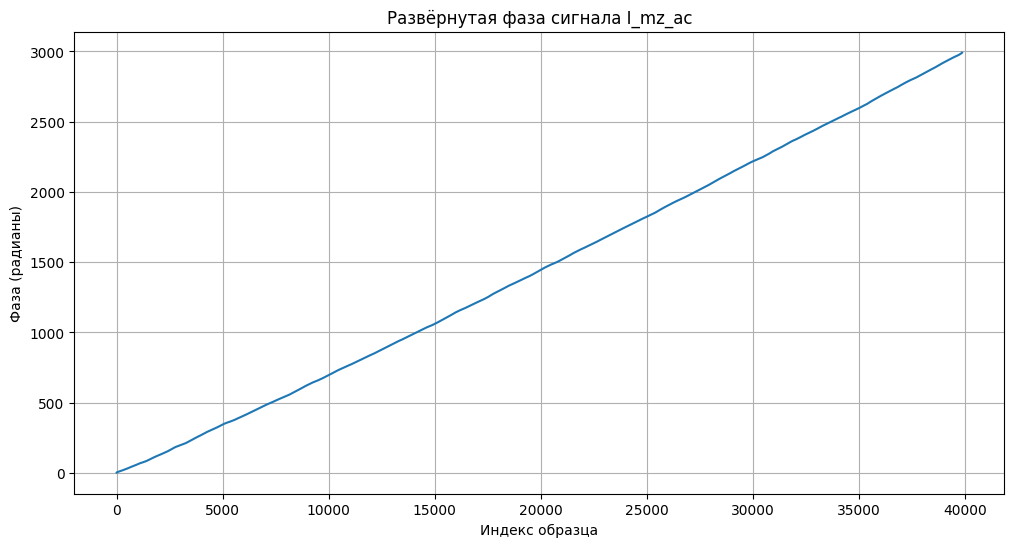

In [ ]:
#@title linearize_by_phase

def linearize_by_phase(df):
    """
    Calculates the phase of I_mz_ac using Hilbert transform and unwraps it.
    Creates a new column 'Phase_mz' in the DataFrame.

    Args:
        df (pandas.DataFrame): DataFrame containing the 'I_mz_ac' column.

    Returns:
        pandas.DataFrame: DataFrame with the added 'Phase_mz' column, or the original
                          DataFrame if 'I_mz_ac' is not found.
    """
    # Check if 'I_mz_ac' column exists. If not, print an error and return the original df.
    if 'I_mz_ac' not in df.columns:
        print("Error: 'I_mz_ac' column not found in the DataFrame. Cannot calculate Phase_mz.")
        # Optionally, you could create a placeholder column filled with NaNs
        # df['Phase_mz'] = np.nan
        return df

    # Применение преобразования Гильберта
    hilbert_transform = hilbert(df['I_mz_ac'])

    # Извлечение фазы
    # np.angle возвращает фазу в диапазоне [-pi, pi]
    phase = np.angle(hilbert_transform)

    # Разворачивание фазы
    # np.unwrap корректно обрабатывает переходы через -pi/pi
    df['Phase_mz'] = np.unwrap(phase)

    print("Column 'Phase_mz' created using Hilbert transform and phase unwrap.")
    return df

# Example usage:
# Assuming 'df' is the DataFrame loaded and processed by get_scan_adc_ref
# and already has the 'I_mz_ac' column (due to the previous fix).

# Call get_scan_adc_ref and store the returned DataFrame
# This ensures 'I_mz_ac' is present if the file was loaded successfully
#I_ac = get_scan_adc_ref(193000000000)

# Check if df is not empty before proceeding
if not I_ac.empty:
    # Call the function to add the 'Phase_mz' column
    I_lin = linearize_by_phase(I_ac)

    # Check again if 'Phase_mz' was successfully added before trying to plot
    if 'Phase_mz' in I_lin.columns:
        # Display the first few rows to check the new column
        print(I_lin.head())

        # Optionally, plot the unwrapped phase
        plt.figure(figsize=(12, 6))
        plt.plot(I_lin.index, I_lin['Phase_mz'])
        plt.xlabel('Индекс образца')
        plt.ylabel('Фаза (радианы)')
        plt.title('Развёрнутая фаза сигнала I_mz_ac')
        plt.grid(True)
        plt.show()
    else:
        print("Phase linearization skipped due to missing 'I_mz_ac' column.")

else:
    print("DataFrame is empty after get_scan_adc_ref, skipping linearization and plotting.")

In [ ]:
#@title заново

In [ ]:
#@title привести файлы к одному формату в папке
# --- Скопируйте этот код в ячейку Colab ---

# 2. Импорты и функция обработки
import pandas as pd
import re
from pathlib import Path
import glob

def preproccess_adc(input_filepath: str, output_dir: str = None):
    """
    Reads a CSV file, renames specific columns, and returns the processed DataFrame
    and the target output filepath.
    """
    file = Path(input_filepath)
    match = re.search(r'_(\d+)_(\d+)\.csv$', file.name)
    if not match:
        raise ValueError(f"Filename {file.name} does not match expected pattern.")

    spectrum_number = match.group(1)
    start_freq_raw = int(match.group(2))
    start_freq_hz = start_freq_raw * 1_000_000

    df = pd.read_csv(file)
    df = df.rename(columns={
        'X': 'T_adc',
        'Channel1': 'I_mz_up',
        'Channel7': 'I_adc_up_ref'
    })

    output_path = Path(output_dir) if output_dir else file.parent
    output_path.mkdir(parents=True, exist_ok=True)
    output_name = f"I_adc_up_ref_N={spectrum_number}_Freq={start_freq_hz}.csv"
    output_filepath = output_path / output_name
    return df, output_filepath

def preproccess_adc_ref_all(input_folder: str, output_folder: str = None):
    """
    Mounts Google Drive, processes all 'signals_*.csv' files in input_folder,
    skips files if the expected output already exists.
    """
    # Монтируем Google Drive (если ещё не смонтирован)
    drive.mount('/content/drive', force_remount=False)

    # Подготовка папки вывода
    output_folder = output_folder or input_folder

    # Обработка всех файлов
    for filepath in glob.glob(f'{input_folder}/signals_*.csv'):
        try:
            df, out_file = preproccess_adc(filepath, output_dir=output_folder)
            if out_file.exists():
                print(f'Skipped (exists): {out_file.name}')
                continue
            df.to_csv(out_file, index=False)
            print(f'Processed: {Path(filepath).name} → {out_file.name}')
        except Exception as e:
            print(f'Error processing {filepath}: {e}')

# Пример вызова функции:
preproccess_adc_ref_all('/content/drive/My Drive/Colab Notebooks/OFDR18_12/REF')

In [ ]:
#@title split_updown
# Базовая папка в Google Drive
settings_folder = "/content/drive/My Drive/Colab Notebooks/simulation/ADC/REF"#"

# Папка, где лежат исходные файлы и куда будут сохраняться результаты
# Corrected the path construction for adc_ref_folder
adc_ref_folder = settings_folder

# Имя исходного файла
base_filename = "I_ref_152_(Freq_start=193020000000)_updown.csv"
input_path = os.path.join(adc_ref_folder, base_filename)

# Загрузка исходной таблицы
df = pd.read_csv(input_path)

# Функция для разделения таблицы по временам UP и DOWN с обнулением времени
def split_updown(df, T_UP_START=0.1, T_UP_STOP=0.99, T_DOWN_START=1.1, T_DOWN_STOP=1.99):
    # Выборка для UP
    up_df = df[(df['T_ADC'] >= T_UP_START) & (df['T_ADC'] <= T_UP_STOP)].copy()
    up_df['T_ADC'] -= up_df['T_ADC'].iloc[0]  # обнуление времени

    # Выборка для DOWN
    down_df = df[(df['T_ADC'] >= T_DOWN_START) & (df['T_ADC'] <= T_DOWN_STOP)].copy()
    down_df['T_ADC'] -= down_df['T_ADC'].iloc[0]  # обнуление времени

    return up_df, down_df

# Применение функции разделения
I_adc_up_ref, I_adc_down_ref = split_updown(df)

# Формируем имена для выходных файлов
up_filename = base_filename.replace("_updown.csv", "_up.csv")
down_filename = base_filename.replace("_updown.csv", "_down.csv")

up_path = os.path.join(adc_ref_folder, up_filename)
down_path = os.path.join(adc_ref_folder, down_filename)

# Сохранение результатов в ту же папку Google Drive
I_adc_up_ref.to_csv(up_path, index=False)
I_adc_down_ref.to_csv(down_path, index=False)

print(f"Файлы сохранены:\n  UP:   {up_path}\n  DOWN: {down_path}")

Файлы сохранены:
  UP:   /content/drive/My Drive/Colab Notebooks/simulation/ADC/REF/I_ref_152_(Freq_start=193020000000)_up.csv
  DOWN: /content/drive/My Drive/Colab Notebooks/simulation/ADC/REF/I_ref_152_(Freq_start=193020000000)_down.csv


In [ ]:
#@title  линеаризация, эквидистантирование, обрезка, ханна

from google.colab import drive
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import hilbert, windows

# Папка с входными данными
base_folder = '/content/drive/My Drive/Colab Notebooks/OFDR18_12/REF'

# Функция обработки одного файла
def linearize_by_phase(input_path, PHASE_STEP=0.073, delta_L=2.0, n=1.468):
    # Извлечение N и Freq из имени
    base = os.path.basename(input_path)
    name, _ = os.path.splitext(base)
    m = re.search(r'N=(\d+)_Freq=(\d+)', name)
    if not m:
        raise ValueError(f"Неподдерживаемое имя файла: {base}")
    N_val, Freq_val = m.groups()

    # Имя и путь выходного файла
    out_name = f"I_adc_up_ref_equ_N={N_val}_Freq={Freq_val}.csv"
    out_path = os.path.join(os.path.dirname(input_path), out_name)

    # Пропустить, если уже есть
    if os.path.exists(out_path):
        print(f"Пропущен, уже обработан: {out_name}")
        return out_path

    # Чтение исходных данных
    data = pd.read_csv(input_path)

    # Удаление DC и вычисление фазы
    I_adc_ac = data['I_adc_up_ref'] - data['I_adc_up_ref'].mean()
    I_mz_ac  = data['I_mz_up']      - data['I_mz_up'].mean()
    phase = np.unwrap(np.angle(hilbert(I_mz_ac)))
    if phase[0] > phase[-1]:
        phase = np.unwrap(-phase)
    data['Phase_up'] = phase

    # Эквидистантная фазовая сетка и интерполяция
    direction = np.sign(phase[-1] - phase[0])
    phase_equ = np.arange(len(phase)) * PHASE_STEP * direction
    data['Phase_equ_up'] = phase_equ
    data['I_adc_equ'] = np.interp(phase_equ, phase, I_adc_ac)

    # Вычисление эквивалентной частоты
    factor = 299792458 / (2 * np.pi * delta_L * n)
    data['Freq_equ'] = phase_equ * factor

    # Обрезка до ближайшего меньшего числа степени двойки
    total_pts = len(data)
    trim_pts = 2 ** int(np.floor(np.log2(total_pts)))
    data = data.iloc[:trim_pts].reset_index(drop=True)

    # Применение окна Ханна к I_adc_equ
    I_sig = data['I_adc_equ'].values
    hann = windows.hann(len(I_sig))
    I_win = I_sig * hann

    # Построение графиков
    plt.figure(figsize=(8,4))
    plt.plot(data['T_adc'], data['Phase_up'])
    plt.xlabel('T_adc, с'); plt.ylabel('Phase_up, рад'); plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(data['Freq_equ'], data['I_adc_equ'])
    plt.xlabel('Freq_equ, Гц'); plt.ylabel('I_adc_equ'); plt.grid(True)
    plt.show()

    # FFT → расстояние с окном Ханна
    N_pts = len(I_win)
    d_k = PHASE_STEP / (2 * delta_L)
    fft_vals = np.fft.fft(I_win)
    freqs_k = np.fft.fftfreq(N_pts, d=d_k)
    mask = freqs_k >= 0
    distances = freqs_k[mask] / 2
    fft_mag = np.abs(fft_vals[mask]) / N_pts

    plt.figure(figsize=(8,4))
    plt.plot(distances, fft_mag)
    plt.xlabel('Расстояние, м'); plt.ylabel('Норм. амплитуда'); plt.grid(True)
    plt.show()

    # Сохранение
    data.to_csv(out_path, index=False)
    print(f"Сохранено: {out_name} (точек: {trim_pts})")
    return out_path


# Функция для обработки всех файлов в папке

def linearize_by_phase_all(folder):
    pattern = os.path.join(folder, 'I_adc_up_ref_N=*Freq=*.csv')
    files = glob.glob(pattern)
    if not files:
        print("Файлы не найдены по шаблону в папке:", folder)
        return
    for f in files:
        try:
            linearize_by_phase(f)
        except Exception as e:
            print(f"Ошибка при обработке {os.path.basename(f)}: {e}")
    print("Обработка всех файлов завершена.")


# Запуск обработки всех файлов
linearize_by_phase_all(base_folder)

